In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

State Variable (Y)

1) Y = [θ, ω, ] ; [angle; ang_vel]
2) dY/dt = [ω, α] ; [ang_vel, ang_accel]

In [7]:
class MotorSim():
    def __init__(self, dt = 0.1, inertia=1, damping=1, springk=0, y0=0, yd0=0):
        self.dt = dt
        self.time = torch.zeros((1))
        self.Y = torch.tensor((y0, yd0), dtype=torch.float32)
        self.vel_old = torch.zeros((1))
        self.acc = torch.zeros((1))
        # Motor Parameters
        self.I = inertia
        self.D = damping
        self.K = springk 
        self.Torque_Motor = 0
        self.Torque_Shaft = 0
        
        # Logging Stuff
        self.data_dict = {}
        self.data_dict["Time"] = []
        self.data_dict["Pos"] = []
        self.data_dict["Vel"] = []
        self.data_dict["Acc"] = []
        self.data_dict["Torque"] = []
        self.data_dict["Power"] = []
        
        # State = [x, xd, torque, k1, k2]
        #Transfer Matrix 
        self.A = torch.tensor( ((1,0,0,0,0,0,0),
                                (0,1,0,0,0,0,0),
                                (0,0,1,0,0,0,0),
                                (0,1,0,-1,self.dt/4,0,self.dt*(1/4-np.sqrt(3)/6)),
                                (-self.K/self.I, -self.D/self.I, 1/self.I, -self.K*self.dt/self.I/4, -self.D*self.dt/self.I/4 - 1, -self.K*self.dt/self.I*(1/4-np.sqrt(3)/6), -self.D*self.dt/self.I*(1/4-np.sqrt(3)/6)),
                                (0,1,0,0,self.dt*(1/4+np.sqrt(3)/6),-1,self.dt/4),
                                (-self.K/self.I, -self.D/self.I, 1/self.I, -self.K*self.dt/self.I*(1/4+np.sqrt(3)/6), -self.D*self.dt/self.I*(1/4+np.sqrt(3)/6), -self.K*self.dt/self.I/4, -self.D*self.dt/self.I/4 - 1)),
                              dtype=torch.float32)
        
        self.B = torch.tensor( ((0,),
                                (0,),
                                (0,),
                                (0,),
                                (0,),
                                (0,),
                                (0,)),
                             dtype=torch.float32)
        
        
        print("Starting Motor Sim")
        print("Initial State (θ, ω) : {}".format(self.Y))
        
    def step(self, input_torque):
        self.data_dict["Time"].append(self.time.clone().numpy())
        self.data_dict["Pos"].append(self.Y[0].clone().numpy())
        self.data_dict["Vel"].append(self.Y[1].clone().numpy())
        self.data_dict["Torque"].append(input_torque.clone().numpy())
        
        self.Y = self.backward_euler(self.time, self.Y, input_torque)
        
        vel_diff = self.Y[1] - self.vel_old
        self.acc = vel_diff/self.dt
        self.vel_old = self.Y[1].clone()
        
        self.data_dict["Acc"].append(self.acc.clone().numpy())
        PowMech = input_torque*self.Y[1] - self.D*self.Y[1]*self.Y[1]
        self.data_dict["Power"].append(PowMech.clone().numpy())
        
        self.time += self.dt
        
    def backward_euler(self, t, Y, input_torque):
        self.B = torch.tensor( ((Y[0],),
                                (Y[1],),
                                (input_torque,),
                                (0,),
                                (0,),
                                (0,),
                                (0,)),
                             dtype=torch.float32)
        
        X = torch.linalg.solve(self.A,self.B)
        Y[0] += self.dt*(X[3,0] + X[5,0])/2
        Y[1] += self.dt*(X[4,0] + X[6,0])/2
        
        return Y
    
    
    def plot(self):
        f, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(2, 2, figsize=(20, 20))

        y_max = 2
        y_min = -y_max

        ax1.plot(self.data_dict["Time"], self.data_dict["Torque"])
        ax1.set_title("Input Torque")
        ax1.set_ylim([y_min, y_max])
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Torque (nm)")
        ax1.grid(True)

        ax2.plot(self.data_dict["Time"], self.data_dict["Pos"])
        ax2.set_title("Position")
        ax2.set_ylim([y_min, y_max])
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Pos (rad)")
        ax2.grid(True)

        ax3.plot(self.data_dict["Time"], self.data_dict["Vel"])
        ax3.plot(self.data_dict["Time"], self.data_dict["Acc"])
        ax3.set_title("Velocity / Acceleration")
        ax3.set_xlabel("Time (s)")
        ax3.set_ylabel("Vel (rad/s), Accel (rad/s/s")
        ax3.set_ylim([y_min, y_max])
        ax3.grid(True)
        ax3.legend(['Velocity', 'Acceleration'])
        
        ax4.plot(self.data_dict["Time"], self.data_dict["Power"])
        ax4.set_title("Mechanical Power")
        ax4.set_ylim([y_min, y_max])
        ax4.set_xlabel("Time (s)")
        ax4.set_ylabel("Power (W)")
        ax4.grid(True)
        
        plt.show()
    


Starting Motor Sim
Initial State (θ, ω) : tensor([1., 0.])


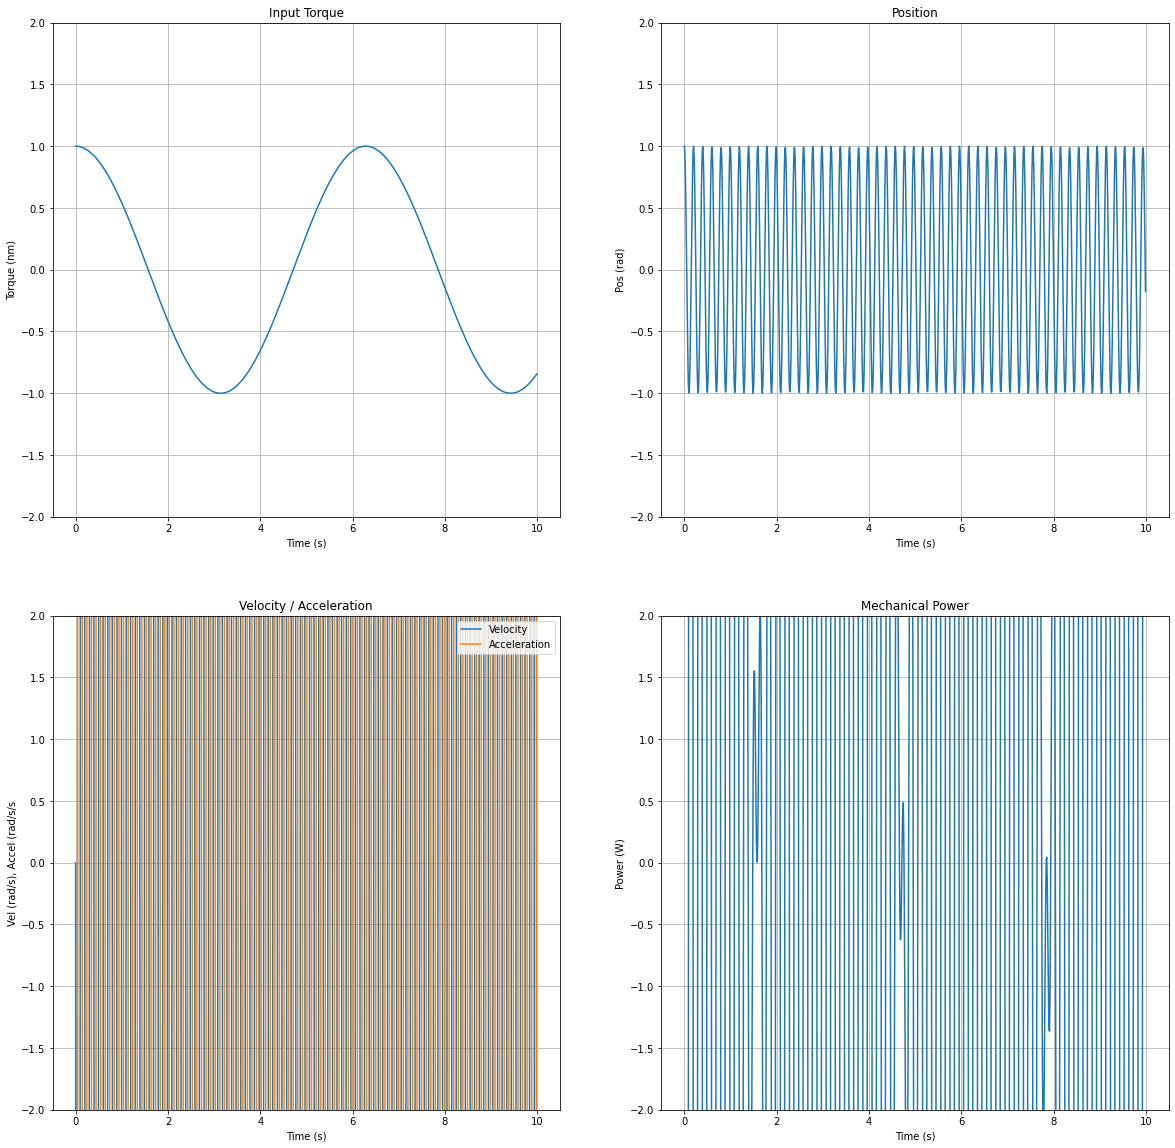

In [26]:
def torque_function(time):
    torque = torch.cos(time)*1
    return torque

ms = MotorSim(dt=0.01, inertia=1, damping=0, springk=1000, y0=1, yd0=0)
# ms.Y[0] = -1

motor_torque = torque_function(ms.time)
for _ in range(1000):
    ms.step(motor_torque[0])
    motor_torque = torque_function(ms.time)    
    
ms.plot()
# ms.data_dict['Torque']